# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)
1. p (Autoregression Order): The number of lag observations included in the model.
2. d (Differencing Order): The number of times the data have had past values subtracted (to make the data stationary).
3. q (Moving Average Order): The size of the moving average window.

In [1255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1: Load and Preprocess the Dataset

In [1256]:
Canadian_data=pd.read_csv('Canadian Car Sales.csv')

Canadian_data.reset_index(inplace=True)
Canadian_data = Canadian_data[['REF_DATE', 'VALUE']]

Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])

print(Canadian_data.dtypes)
Canadian_data.head()

REF_DATE    datetime64[ns]
VALUE              float64
dtype: object


,REF_DATE,VALUE
0,1953-01-01,21742.0
1,1953-02-01,28711.0
2,1953-03-01,36867.0
3,1953-04-01,39903.0
4,1953-05-01,37717.0


In [1257]:
# display last 12 rows
Canadian_data.tail(12)

,REF_DATE,VALUE
6570,2023-03-01,5813312.0
6571,2023-04-01,5666677.0
6572,2023-05-01,6718800.0
6573,2023-06-01,6069241.0
6574,2023-07-01,5507734.0
6575,2023-08-01,6101383.0
6576,2023-09-01,6078980.0
6577,2023-10-01,5790248.0
6578,2023-11-01,5590523.0
6579,2023-12-01,5127895.0


In [1258]:
Canadian_data=Canadian_data.tail(120)

In [1259]:
# Check for missing values
print(Canadian_data.isnull().sum())

REF_DATE    0
VALUE       0
dtype: int64


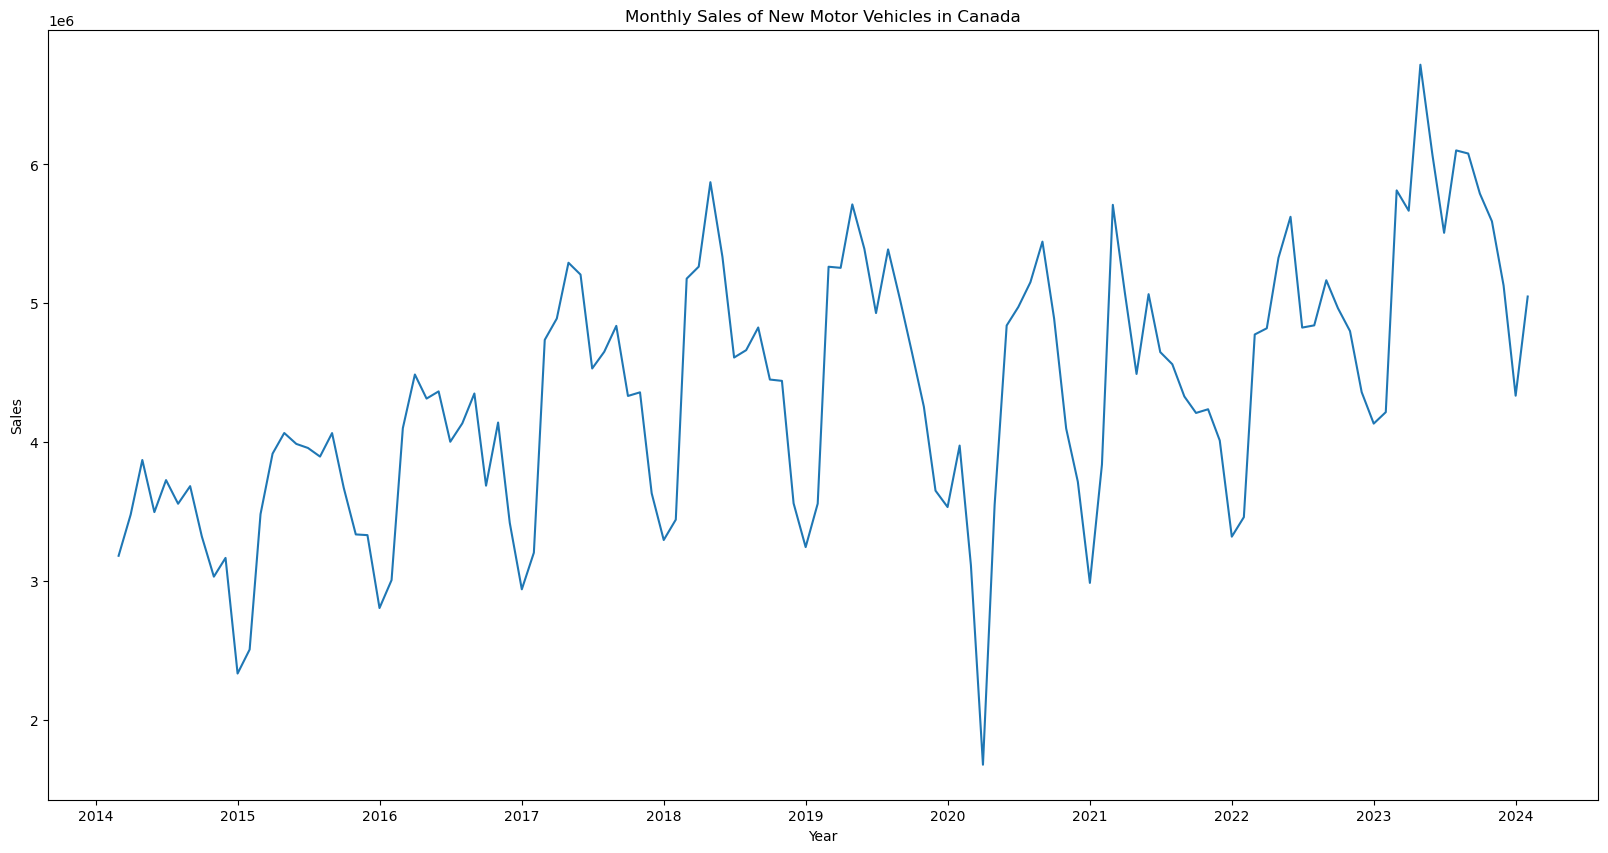

In [1260]:
# Adjust figure size
plt.figure(figsize=(20, 10))

# Plot the lineplot
sns.lineplot(data=Canadian_data, x='REF_DATE', y='VALUE')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Monthly Sales of New Motor Vehicles in Canada')
plt.show()

## Step 2: Check for Stationarity

In [1261]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the Dickey-Fuller test on the 'VALUE' column
test_stationarity(Canadian_data['VALUE'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.488778
p-value                          0.894188
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


If the p-value is less than 0.05 and the test statistic is less than the critical values, we can conclude the series is stationary.

But it is not, we'll consider applying transformations to make it stationary.

## Step 3: Data Transformation

In [1262]:
# First differencing
# Canadian_data['VALUE_diff'] = Canadian_data['VALUE'].diff()

Canadian_data['Sales_First_Difference'] = Canadian_data['VALUE'] - Canadian_data['VALUE'].shift(1)
Canadian_data['Seasonal_First_Difference']=Canadian_data['VALUE']-Canadian_data['VALUE'].shift(12)
Canadian_data.dropna().head()

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference
6474,2015-03-01,3480674.0,975479.0,300151.0
6475,2015-04-01,3916593.0,435919.0,439526.0
6476,2015-05-01,4065298.0,148705.0,194496.0
6477,2015-06-01,3986752.0,-78546.0,491330.0
6478,2015-07-01,3957430.0,-29322.0,231573.0


In [1263]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")


# Again testing if data is stationary
adfuller_test(Canadian_data['Seasonal_First_Difference'].dropna())

ADF Test Statistic : -2.1141176329579205
p-value : 0.23887585315325482
#Lags Used : 12
Number of Observations : 95
weak evidence against null hypothesis,indicating it is non-stationary 


<Axes: >

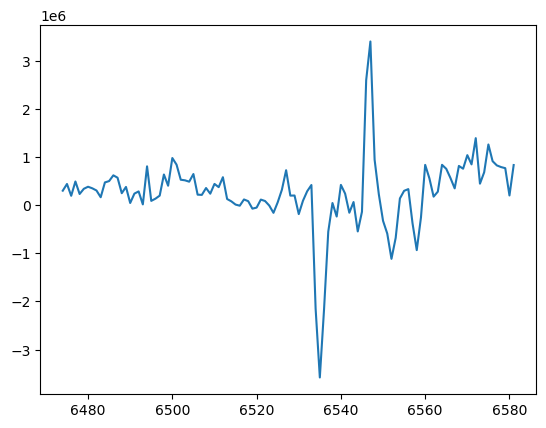

In [1264]:
Canadian_data['Seasonal_First_Difference'].plot()

## Step 4: Identify and Remove Outliers

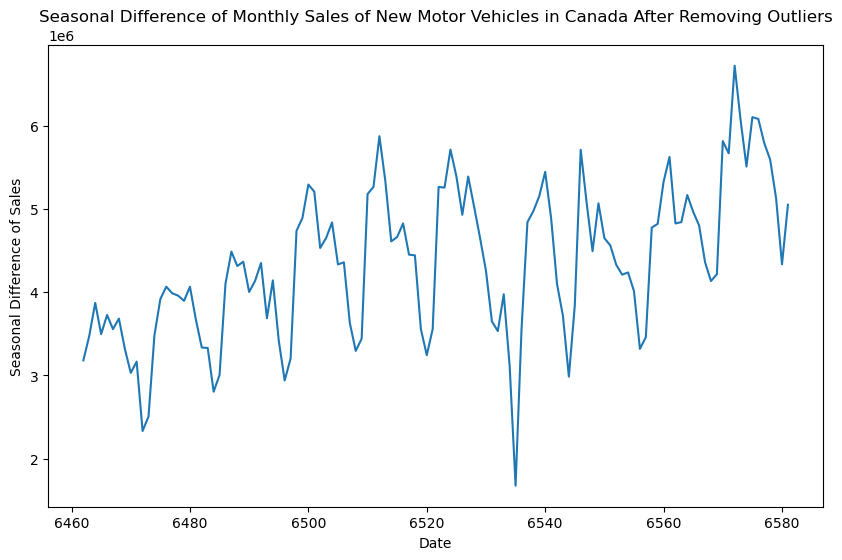

In [1265]:
# Calculate IQR
Q1 = Canadian_data['VALUE'].quantile(0.25)
Q3 = Canadian_data['VALUE'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_data = Canadian_data[(Canadian_data['VALUE'] >= lower_bound) & (Canadian_data['VALUE'] <= upper_bound)]

# Plot to see data after removing outliers
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['VALUE'])
plt.title('Seasonal Difference of Monthly Sales of New Motor Vehicles in Canada After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('Seasonal Difference of Sales')
plt.show()

## Step 5: Split the Data into Training and Test Sets

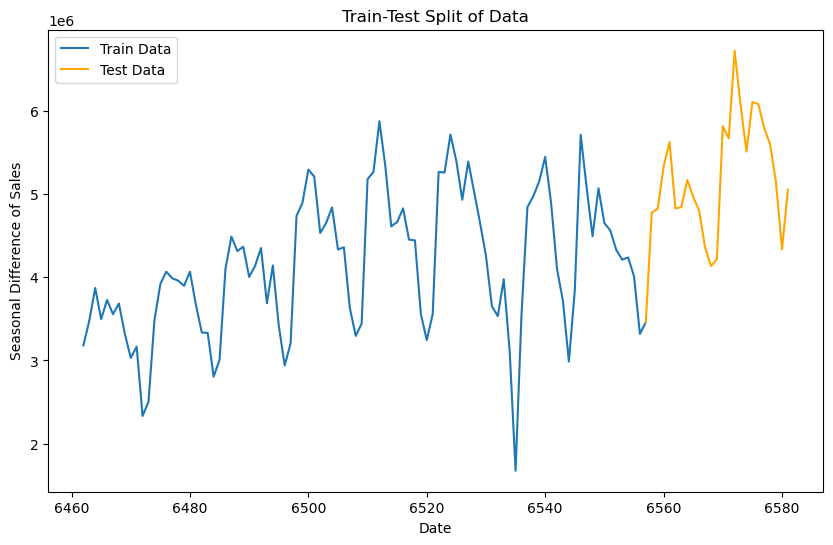

In [1266]:
# Calculate the split point
split_point = int(len(filtered_data) * 0.8)

# Split into training and test sets
train_data = filtered_data[:split_point]
test_data = filtered_data[split_point-1:]

# Plot both to visually inspect the split
plt.figure(figsize=(10, 6))
plt.plot(train_data['VALUE'], label='Train Data')
plt.plot(test_data['VALUE'], label='Test Data', color='orange')
plt.title('Train-Test Split of Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Difference of Sales')
plt.legend()
plt.show()

## Step 6: Model Identification

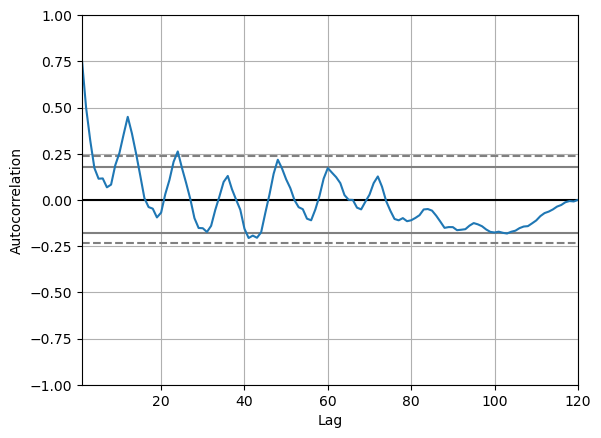

In [1267]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Canadian_data['VALUE'])
plt.show()

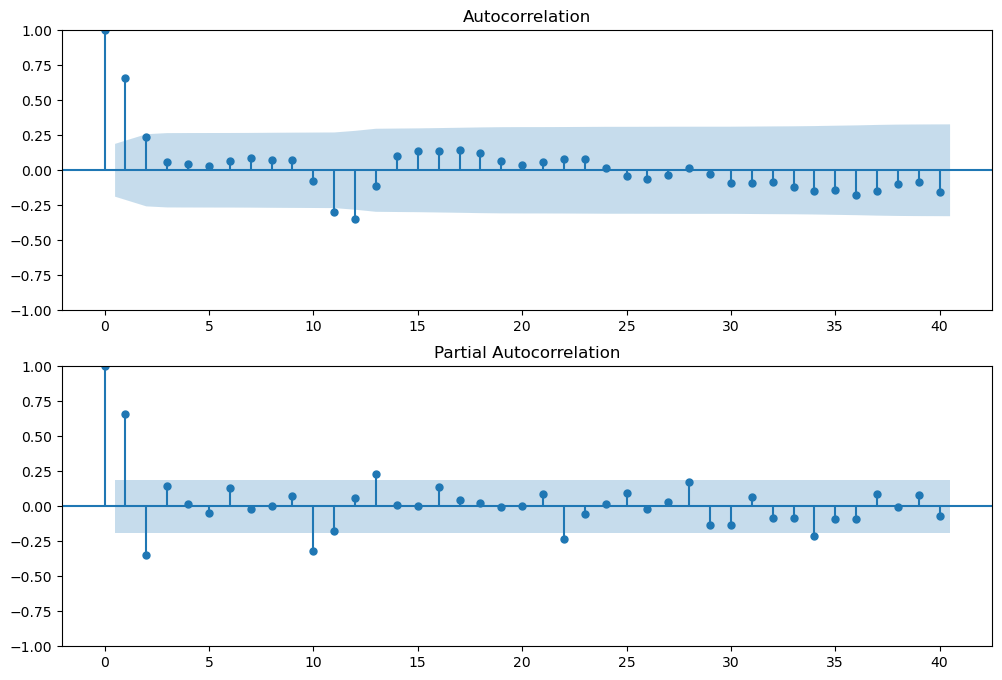

In [1268]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax2)

## Step 7: Model Fitting

In [1269]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(Canadian_data['VALUE'], order=(12, 2, 1))
model_fit = model.fit()
model_fit.summary()

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                  120
Model:                ARIMA(12, 2, 1)   Log Likelihood               -1716.487
Date:                Mon, 22 Apr 2024   AIC                           3460.973
Time:                        09:16:41   BIC                           3499.763
Sample:                             0   HQIC                          3476.723
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0472      0.128     -0.369      0.712      -0.298       0.203
ar.L2         -0.3026      0.119     -2.533      0.011      -0.537      -0.068
ar.L3         -0.3773      0.124     -3.041      0.002      -0.621      -0.134
ar.L4         -0.2832      0.135     -2.105      0.035      -0.547      -0.019
ar.L5         -0.3100      0.134     -2.311      0.021      -0.573      -0.047
ar.L6         -0.2053      0.128     -1.609      0.108      -0.455       0.045
ar.L7         -0.3310      0.150     -2.210      0.027      -0.625      -0.038
ar.L8         -0.3472      0.171     -2.027      0.043      -0.683      -0.011
ar.L9         -0.0984      0.123     -0.797      0.425      -0.340       0.144
ar.L10        -0.2877      0.106     -2.725      0.006      -0.495      -0.081
ar.L11        -0.1779      0.204     -0.872      0.383      -0.578       0.222
ar.L12         0.2477      0.099      2.512      0.012       0.054       0.441
ma.L1         -0.9656      0.060    -16.015      0.000      -1.084      -0.847
sigma2      2.815e+11   2.32e-13   1.21e+24      0.000    2.82e+11    2.82e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                74.86
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.14
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+40. Standard errors may be unstable.
"""

## Step 8: Model Evaluation and Forecasting

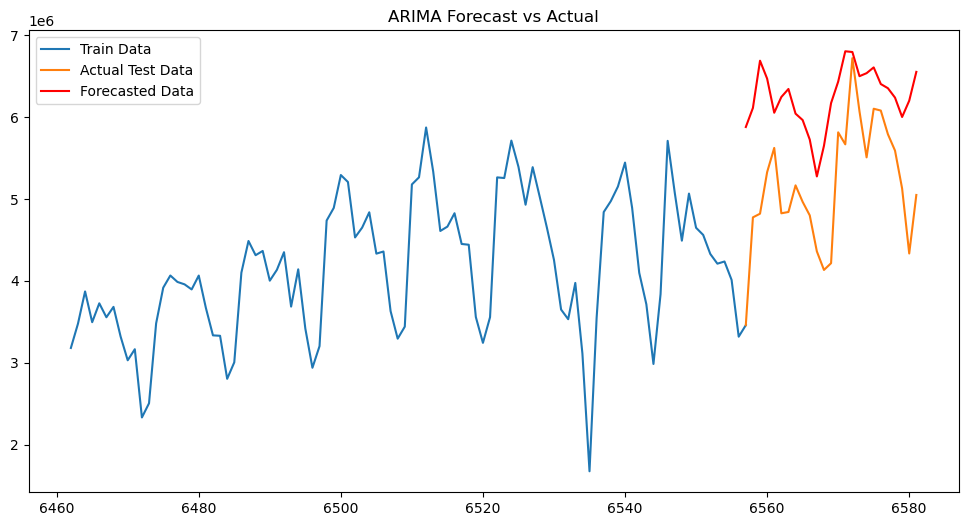

MSE: 1479045686737.295, MAE: 1074662.7685604114, RMSE: 1216160.2224778177


In [1270]:
# Make forecast
forecast = model_fit.forecast(steps=len(test_data))

# Visual comparison
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['VALUE'], label='Train Data')
plt.plot(test_data.index, test_data['VALUE'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(test_data['VALUE'], forecast)
mae = mean_absolute_error(test_data['VALUE'], forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

In [1271]:
# Canadian_data['forecast']=model_fit.predict(start=0,end=120,dynamic=True)
# Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [1272]:
Canadian_data.shape

(120, 4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47395D+01    |proj g|=  8.36418D-01


/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  1.43853D+01    |proj g|=  1.00850D-01

At iterate   10    f=  1.43189D+01    |proj g|=  3.28730D-02

At iterate   15    f=  1.43137D+01    |proj g|=  4.08676D-02

At iterate   20    f=  1.43056D+01    |proj g|=  3.59041D-02

At iterate   25    f=  1.43041D+01    |proj g|=  4.42859D-03

At iterate   30    f=  1.43041D+01    |proj g|=  8.98964D-04

At iterate   35    f=  1.43041D+01    |proj g|=  2.13353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     38     44      1     0     0   1.069D-04   1.430D+01
  F =   14.304054231357101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

<Axes: >

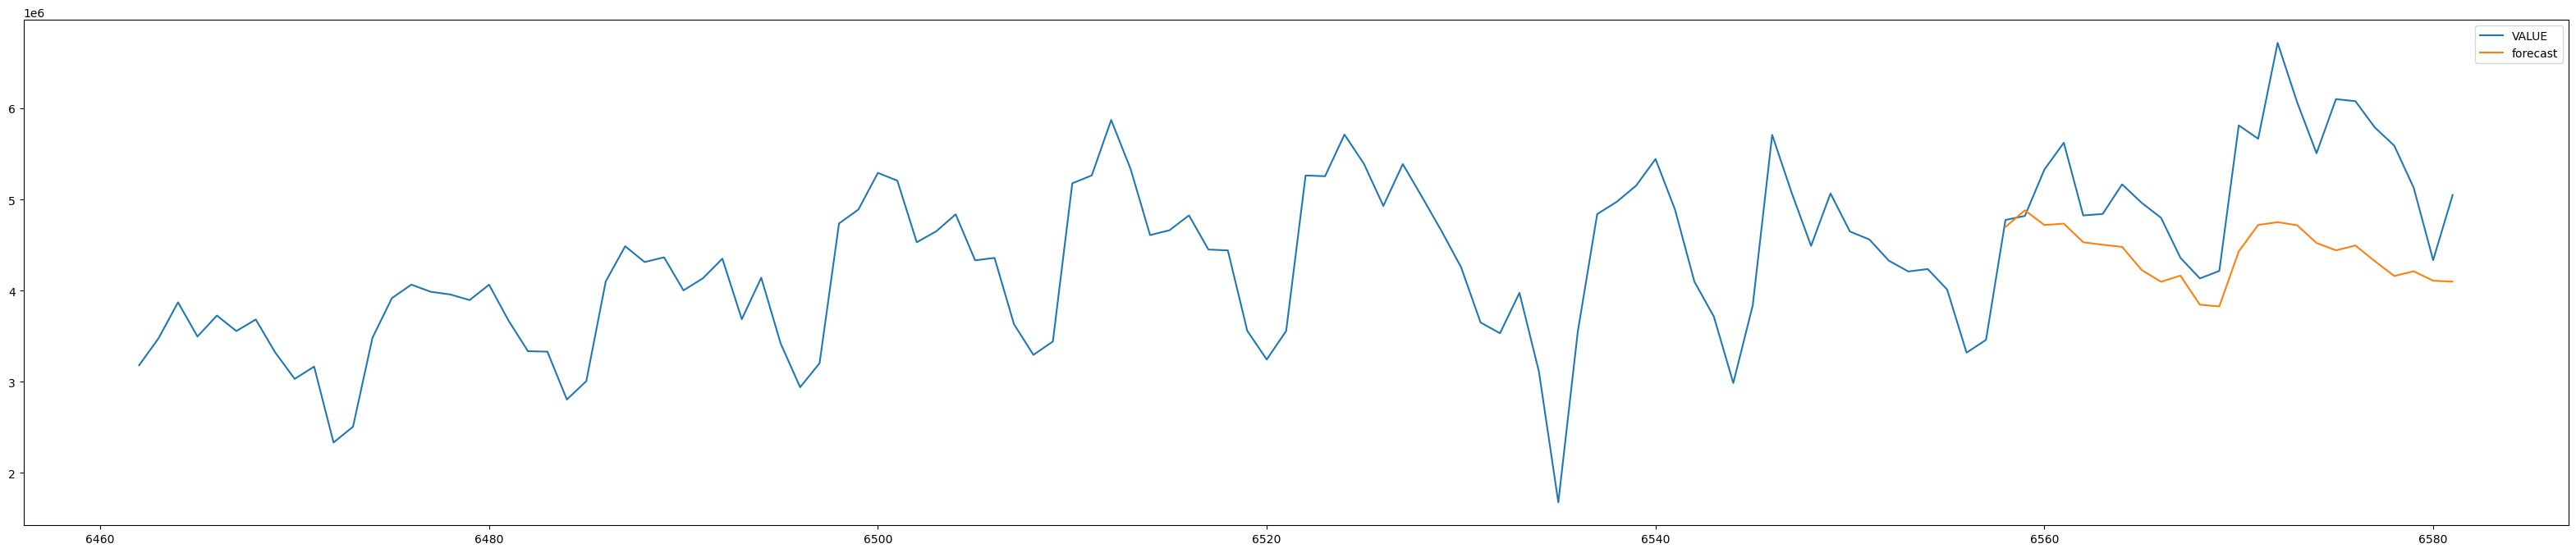

In [1273]:
import statsmodels.api as sm
# model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1),seasonal_order=(12,2,1,12))
model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1))

results=model.fit()
Canadian_data['forecast']=results.predict(start=96,end=120,dynamic=True)
Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [1274]:
Canadian_data.tail(12)

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference,forecast
6570,2023-03-01,5813312.0,1597808.0,1038250.0,4.430219e+06
6571,2023-04-01,5666677.0,-146635.0,846887.0,4.720604e+06
6572,2023-05-01,6718800.0,1052123.0,1391512.0,4.750457e+06
6573,2023-06-01,6069241.0,-649559.0,446112.0,4.717584e+06
6574,2023-07-01,5507734.0,-561507.0,682947.0,4.522174e+06
6575,2023-08-01,6101383.0,593649.0,1260526.0,4.442064e+06
6576,2023-09-01,6078980.0,-22403.0,913036.0,4.494637e+06
6577,2023-10-01,5790248.0,-288732.0,825907.0,4.322388e+06
6578,2023-11-01,5590523.0,-199725.0,791034.0,4.160220e+06
6579,2023-12-01,5127895.0,-462628.0,768067.0,4.211513e+06


<Axes: >

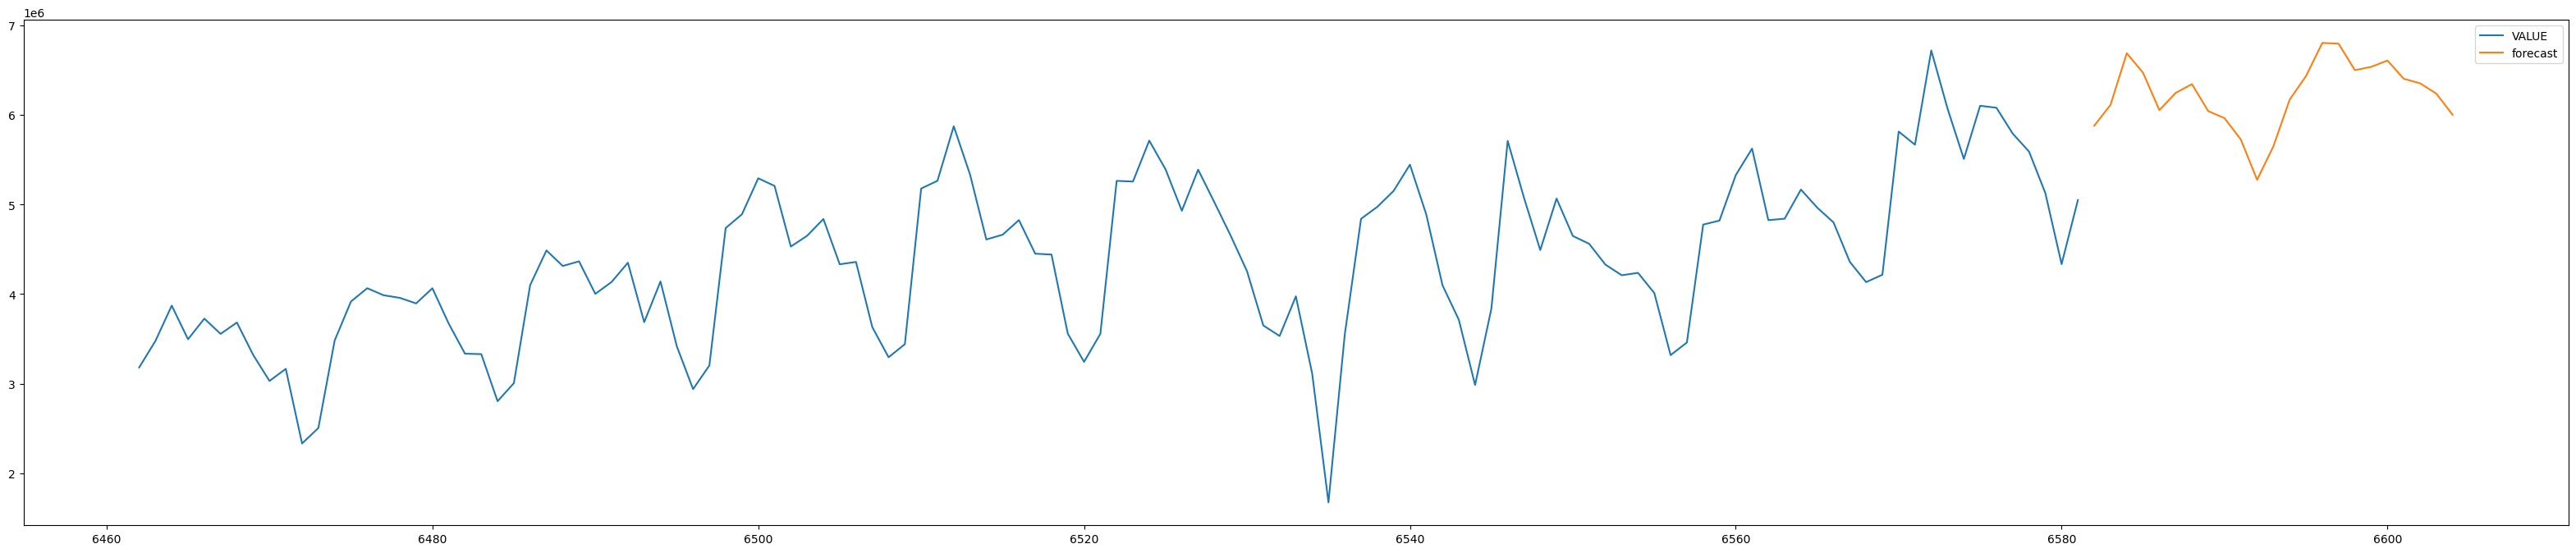

In [1275]:
from pandas.tseries.offsets import DateOffset

# Convert the last date in the index to a Timestamp object
last_date = Canadian_data['REF_DATE'].index[-1]
#last_date = pd.to_datetime(last_date)

# Now you should be able to add DateOffset to the last date in the index
future_dates = [last_date + x for x in range(0, 24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=Canadian_data.columns)

# Concatenate the original dataframe with the future dates dataframe
future_df = pd.concat([Canadian_data, future_datest_df])

# Assuming 'results' is your fitted model and it's already defined
future_df['forecast'] = results.predict(start=len(Canadian_data), end=len(Canadian_data)+24, dynamic=True)
future_df[['VALUE', 'forecast']].plot(figsize=(40, 8))


In [1276]:
future_df[['VALUE', 'forecast']].tail(30)

,VALUE,forecast
6575,6101383.0,NaN
6576,6078980.0,NaN
6577,5790248.0,NaN
6578,5590523.0,NaN
6579,5127895.0,NaN
6580,4334053.0,NaN
6581,5048656.0,NaN
6582,NaN,5.878318e+06
6583,NaN,6.111070e+06
6584,NaN,6.687707e+06
